In [1]:
# Can we make a vector metric for FOnV
import numpy as np
from rubin_sim.maf import BaseMetric

import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline
import os

import datetime

In [2]:
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)

In [3]:
class AccumulateCountMetric(BaseMetric):
    """
    Calculate the accumulated Count at given time points
    """

    def __init__(
        self, time_points, time_col="night", function=np.add, metric_dtype=float, **kwargs
    ):
        self.function = function
        super().__init__(
            col=time_col, metric_dtype=metric_dtype, **kwargs
        )
        self.time_col = time_col
        self.time_points = time_points
        self.shape = self.time_points.size

    def run(self, data_slice, slice_point=None):
        data_slice.sort(order=self.time_col)
        to_count = np.ones(data_slice.size)
        result = self.function.accumulate(to_count)
        indices = np.searchsorted(data_slice[self.time_col], self.time_points, side="right")
        # If we have time points beyond the end, pull it back
        indices[np.where(indices >= np.size(result))] = np.size(result) - 1
        result = result[indices]
        result[np.where(indices == 0)] = 0
        return result

In [4]:
class FONvTime(BaseMetric):
    """Given a vector metric with number of observations over time, convert to FONv over time
    """
    def __init__(self, asky=18000.0, stat=np.median, **kwargs):
        super().__init__(**kwargs)
        self.asky = asky
        self.stat = stat
        # This should get full vector metric passed
        # with masked values set to zero
        self.mask_val = 0 

    def run(self, data_slice, slice_point=None):
        # Should be able to add a check on data_slice dim,
        # then just promote it to an (N,1) array if
        # it's a single map. 
        n_pix_heal = data_slice["metricdata"][:,0].size
        nside = hp.npix2nside(n_pix_heal)
        pix_area = hp.nside2pixarea(nside, degrees=True)
        n_pix_needed = int(np.ceil(self.asky/pix_area))
        # sort by value
        data = data_slice["metricdata"].copy()
        data.sort(axis=0)
        # Crop down to the desired sky area
        data = data[n_pix_heal-n_pix_needed:, :]
        result = self.stat(data, axis=0)
        return result
        
        

In [5]:
bundle_list = []
nside = 128
time_points = np.arange(0,3652, 1)

metric = maf.AccumulateCountMetric(times=time_points)
sql = ''
slicer = maf.slicers.HealpixSlicer(nside=nside)
plot_dict = {}
summary_stats = [FONvTime()]
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name, plot_dict=plot_dict, summary_metrics=summary_stats))



Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [6]:
first = datetime.datetime.now()

bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()
#bg.plot_all(closefigs=False)
end = datetime.datetime.now()

/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/db/results_db.py:617: UserWarning: Warning! Cannot save summary statistic that is not a simple float or int
  warnings.warn("Warning! Cannot save summary statistic that is not a simple float or int")


In [7]:
print("run_time=", end-first)

run_time= 0:02:08.861899


In [8]:
bd

{'baseline_v4_3_1_10yrs_AccumulateCount_night_night_HEAL': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x302112c00>}

In [9]:
# ok, now we have number of visits over time as an array
mv = bd['baseline_v4_3_1_10yrs_AccumulateCount_night_night_HEAL'].metric_values

In [10]:
mv.data

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  2.,   3.,   3., ..., 117., 117., 117.],
       [  2.,   3.,   3., ..., 116., 116., 116.],
       [  2.,   5.,   5., ...,  93.,  93.,  93.]], shape=(196608, 3652))

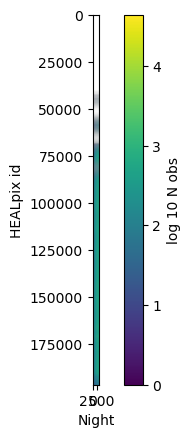

In [11]:
plt.imshow(np.log10(mv.filled()))
plt.xlabel('Night')
plt.ylabel('HEALpix id')
cb = plt.colorbar()
cb.set_label('log 10 N obs')

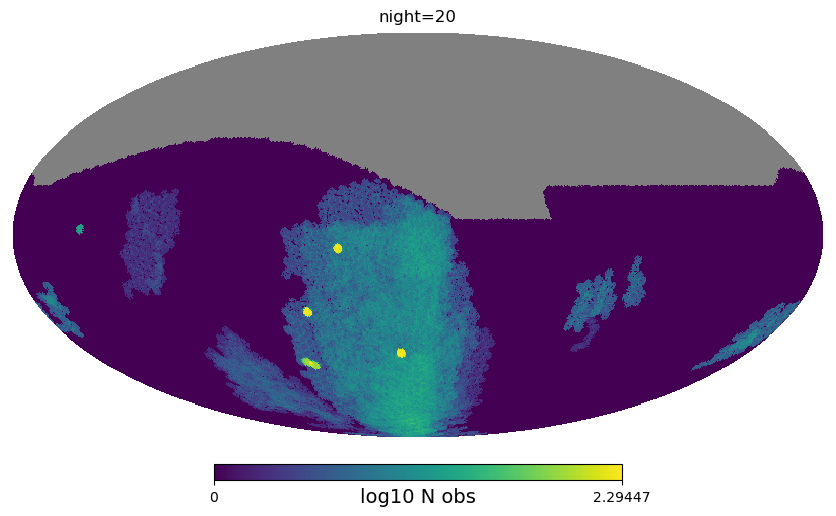

In [12]:
# Take a look at time-value 20. 
hp.mollview(np.log10(mv[:,20]), title='night=20', unit='log10 N obs')

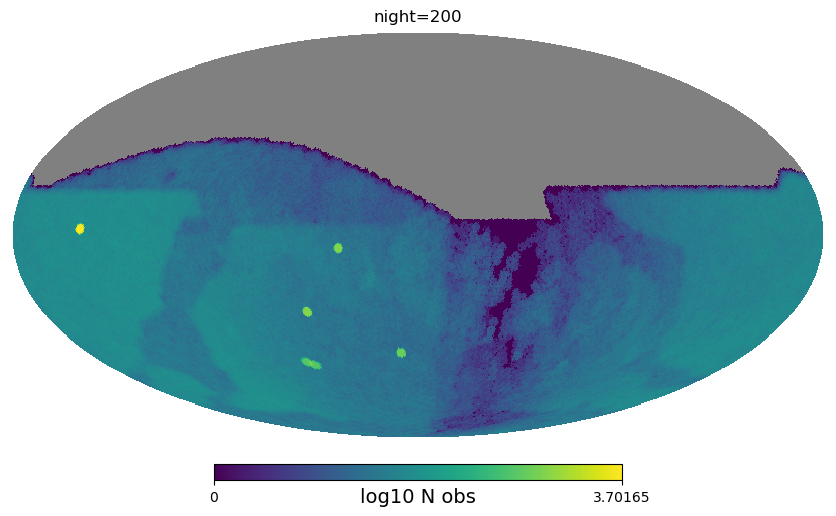

In [13]:
hp.mollview(np.log10(mv[:,200]), title='night=200', unit='log10 N obs')

In [14]:
# Summary value
sv = bd['baseline_v4_3_1_10yrs_AccumulateCount_night_night_HEAL'].summary_values['FONvTime']

Text(0.5, 1.0, 'Median N visits in top 18,000 sq deg')

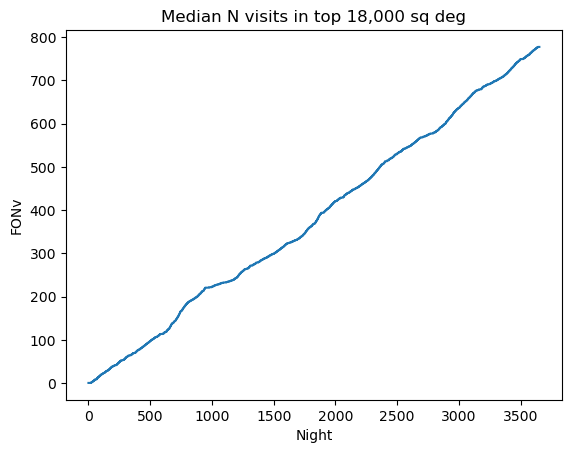

In [15]:
fig, ax = plt.subplots()
ax.plot(time_points, sv)
ax.set_xlabel('Night')
ax.set_ylabel('FONv')
ax.set_title('Median N visits in top 18,000 sq deg')

In [16]:
# time out the regular way

bundle_list = []
metric = maf.metrics.CountExplimMetric(metric_name="fO")
sql = ''
slicer = maf.slicers.HealpixSlicer(nside=nside)
plot_dict = {}
summary_stats = [maf.metrics.FONv(
            nside=nside,
            norm=False,
            metric_name="fONv")]
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name, plot_dict=plot_dict, summary_metrics=summary_stats))



Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [17]:
first = datetime.datetime.now()

bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()
#bg.plot_all(closefigs=False)
end = datetime.datetime.now()

In [18]:
print("run_time=", end-first)

run_time= 0:00:57.429667


In [19]:
bundle_list[0].summary_values

{'fONv': array([('MedianNvis', 770.), ('MinNvis', 719.)],
       dtype=[('name', '<U20'), ('value', '<f8')])}